In [1]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

In [2]:
def recoverPose(E, pts1, pts2, K, mask):
    U, S, V_T = np.linalg.svd(E)
    W = np.array([[0, -1, 0], [1, 0, 0], [0, 0, 1]])
    R = []
    C = []
    R.append(np.dot(U, np.dot(W, V_T)))
    R.append(np.dot(U, np.dot(W, V_T)))
    R.append(np.dot(U, np.dot(W.T, V_T)))
    R.append(np.dot(U, np.dot(W.T, V_T)))
    C.append(U[:, 2])
    C.append(-U[:, 2])
    C.append(U[:, 2])
    C.append(-U[:, 2])
    for i in range(4):
        if (np.linalg.det(R[i]) < 0):
            R[i] = -R[i]
            C[i] = -C[i]
    return 0, R[1], C[1].reshape(3,1), mask

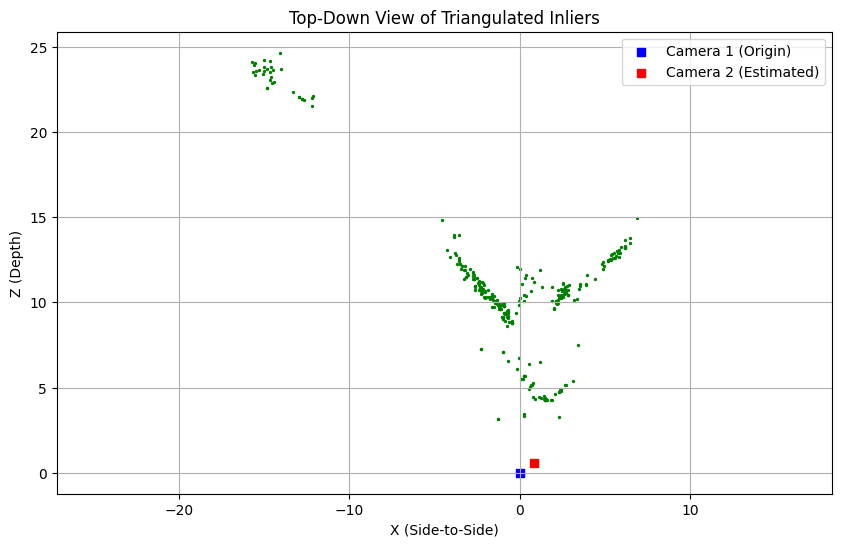

In [3]:
def extract_sift_features(img):
    sift = cv2.SIFT_create()
    kp, features = sift.detectAndCompute(cv2.cvtColor(img, cv2.COLOR_RGB2GRAY), None)
    return kp, features

def match_sift_features(des1, des2):
    index_params = dict(algorithm=1, trees=5)
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(des1, des2, k=2)
    return matches

def sift_match_images(img1, img2):
    kp1, des1 = extract_sift_features(img1)
    kp2, des2 = extract_sift_features(img2)
    matches = match_sift_features(des1, des2)
    return matches, kp1, kp2

def get_good_matches(matches):
    good = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            good.append(m)
    return good

BASE_DIR = "/home/deveshdatwani/sfm/P3Data/"
image_names = ["1.png", "2.png", "3.png", "4.png", "5.png"]
K = np.array([531.122155322710, 0, 407.192550839899,
              0, 531.541737503901, 313.308715048366,
              0, 0, 1]).reshape((3,3))

img = [cv2.imread(os.path.join(BASE_DIR, name)) for name in image_names]
matches, kp1, kp2 = sift_match_images(img[0], img[1])
good_matches = get_good_matches(matches)

pts1 = np.float32([kp1[m.queryIdx].pt for m in good_matches])
pts2 = np.float32([kp2[m.trainIdx].pt for m in good_matches])

E, mask = cv2.findEssentialMat(pts1, pts2, K, method=cv2.RANSAC, prob=0.99, threshold=1.0)
_, R, t, mask_pose = cv2.recoverPose(E, pts1, pts2, K, mask=mask)

inlier_pts1 = pts1[mask_pose.ravel() > 0]
inlier_pts2 = pts2[mask_pose.ravel() > 0]

P1 = K @ np.eye(3, 4)
P2 = K @ np.hstack((R, t))

points_4d = cv2.triangulatePoints(P1, P2, inlier_pts1.T, inlier_pts2.T)
points_3d = (points_4d[:3] / points_4d[3]).T

plt.figure(figsize=(10, 6))
plt.scatter(points_3d[:, 0], points_3d[:, 2], c='green', s=2)
plt.scatter(0, 0, c='blue', marker='s', label='Camera 1 (Origin)')
plt.scatter(-t[0], -t[2], c='red', marker='s', label='Camera 2 (Estimated)')
plt.xlabel('X (Side-to-Side)')
plt.ylabel('Z (Depth)')
plt.title('Top-Down View of Triangulated Inliers')
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.show()

In [6]:
def save_ply(points, filename):
    header = f"""ply
format ascii 1.0
element vertex {len(points)}
property float x
property float y
property float z
end_header
"""
    with open(filename, 'w') as f:
        f.write(header)
        for p in points:
            f.write(f"{p[0]} {p[1]} {p[2]}\n")

save_ply(points_3d, "reconstruction.ply")